![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [5]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [6]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

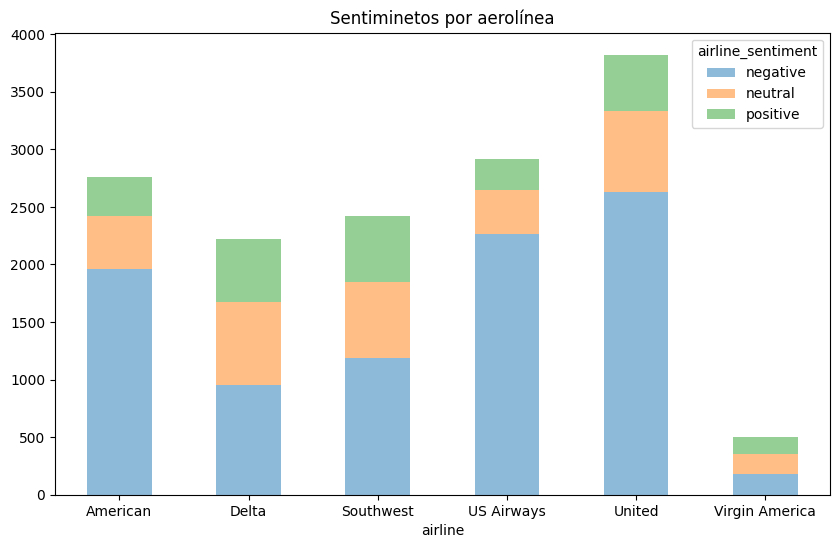

In [7]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train

tweet_id
569577005278064640                          @JetBlue of course I am!!✈️
569633482915209216    @AmericanAir complt incompetence on flt 295.La...
567829997668470785    @SouthwestAir Flight 4968 (N8325D) departs @MC...
569725021951791104    @USAirways does anyone from your airline know ...
567852278893416448                           @united I Want a Plane dad
                                            ...                        
569266206596734976    @SouthwestAir replacing @vitaminwater with bee...
569867943888056320    @AmericanAir at LAX and your service reps just...
569151232738095105    @SouthwestAir Been on hold for over an hour - ...
570049697924009984    @united we would...how do I contact you to dis...
569705380282019841    @JetBlue that's ok! It just sure seemed like i...
Name: text, Length: 9808, dtype: object

In [12]:
y_train

tweet_id
569577005278064640    0
569633482915209216   -1
567829997668470785   -1
569725021951791104   -1
567852278893416448    0
                     ..
569266206596734976    1
569867943888056320   -1
569151232738095105   -1
570049697924009984   -1
569705380282019841    0
Name: airline_sentiment, Length: 9808, dtype: int64

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [13]:
# Celda 1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

cv1 = CountVectorizer(lowercase=True)

In [14]:
X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1 = cv1.transform(X_test)
X_train_cv1.shape

(9808, 12056)

In [15]:
cv1.vocabulary_

{'jetblue': 6206,
 'of': 7768,
 'course': 3393,
 'am': 1680,
 'americanair': 1695,
 'complt': 3218,
 'incompetence': 5893,
 'on': 7815,
 'flt': 4790,
 '295': 508,
 'lav': 6525,
 'delay': 3661,
 'from': 4975,
 'pln': 8327,
 'that': 10546,
 'lnded': 6713,
 'last': 6503,
 'nite': 7566,
 'no': 7580,
 'internet': 6039,
 'and': 1729,
 'poor': 8364,
 'svc': 10323,
 'not': 7655,
 'what': 11670,
 'expect': 4460,
 'southwestair': 9955,
 'flight': 4735,
 '4968': 846,
 'n8325d': 7405,
 'departs': 3705,
 'mco': 7032,
 'enroute': 4292,
 'to': 10724,
 'no_airport': 7582,
 'http': 5713,
 'co': 3090,
 'fd4snvkiem': 4597,
 'usairways': 11325,
 'does': 3962,
 'anyone': 1798,
 'your': 11982,
 'airline': 1584,
 'know': 6426,
 'how': 5694,
 'do': 3953,
 'their': 10562,
 'job': 6254,
 'united': 11192,
 'want': 11570,
 'plane': 8290,
 'dad': 3546,
 'my': 7375,
 '386': 664,
 'dallas': 3556,
 'jacksonville': 6151,
 'fl': 4711,
 'has': 5448,
 'been': 2231,
 'cancelled': 2710,
 'flightled': 4765,
 'one': 7821,
 '

In [16]:
rf1 = RandomForestClassifier()
rf1.fit(X_train_cv1, y_train)

RandomForestClassifier()

In [17]:
predict_rf1 = rf1.predict(X_test_cv1)

In [18]:

from sklearn.metrics import accuracy_score
accuracy_rf1 = accuracy_score(y_test, predict_rf1)
print("Accuracy del modelo Random Forest:", accuracy_rf1)

Accuracy del modelo Random Forest: 0.7706953642384106


### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [19]:
# Celda 2
cv2 = CountVectorizer(lowercase=True, stop_words='english')
X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2 = cv2.transform(X_test)
X_train_cv2.shape

(9808, 11777)

In [20]:
cv2.vocabulary_

{'jetblue': 6081,
 'course': 3335,
 'americanair': 1680,
 'complt': 3163,
 'incompetence': 5775,
 'flt': 4701,
 '295': 508,
 'lav': 6398,
 'delay': 3601,
 'pln': 8147,
 'lnded': 6584,
 'nite': 7417,
 'internet': 5919,
 'poor': 8184,
 'svc': 10116,
 'expect': 4378,
 'southwestair': 9750,
 'flight': 4646,
 '4968': 846,
 'n8325d': 7261,
 'departs': 3645,
 'mco': 6900,
 'enroute': 4218,
 'no_airport': 7432,
 'http': 5599,
 'fd4snvkiem': 4515,
 'usairways': 11078,
 'does': 3899,
 'airline': 1578,
 'know': 6300,
 'job': 6129,
 'united': 10949,
 'want': 11321,
 'plane': 8111,
 'dad': 3487,
 '386': 664,
 'dallas': 3497,
 'jacksonville': 6026,
 'fl': 4622,
 'cancelled': 2658,
 'flightled': 4676,
 'notified': 7519,
 'going': 5114,
 'trying': 10673,
 'make': 6785,
 'probably': 8348,
 'late': 6384,
 'did': 3721,
 'email': 4147,
 'pittsburgh': 8091,
 'international': 5917,
 'look': 6638,
 'forward': 4815,
 'jb': 6057,
 'rt': 9092,
 'bostongarden': 2403,
 'looking': 6642,
 'welcoming': 11393,
 'onbo

In [21]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_cv2, y_train)
predict_rf2 = rf2.predict(X_test_cv2)

In [22]:
accuracy_rf2 = accuracy_score(y_test, predict_rf2)
print("Accuracy del modelo Random Forest:", accuracy_rf2)

Accuracy del modelo Random Forest: 0.7649006622516556


### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [23]:
# Celda 3
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\evaka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:

cv3 = CountVectorizer(lowercase=True, stop_words='english')
X_train_cv3 = cv3.fit_transform(X_train)
X_test_cv3 = cv3.transform(X_test)
X_train_cv3.shape

(9808, 11777)

In [25]:
cv3.vocabulary_

{'jetblue': 6081,
 'course': 3335,
 'americanair': 1680,
 'complt': 3163,
 'incompetence': 5775,
 'flt': 4701,
 '295': 508,
 'lav': 6398,
 'delay': 3601,
 'pln': 8147,
 'lnded': 6584,
 'nite': 7417,
 'internet': 5919,
 'poor': 8184,
 'svc': 10116,
 'expect': 4378,
 'southwestair': 9750,
 'flight': 4646,
 '4968': 846,
 'n8325d': 7261,
 'departs': 3645,
 'mco': 6900,
 'enroute': 4218,
 'no_airport': 7432,
 'http': 5599,
 'fd4snvkiem': 4515,
 'usairways': 11078,
 'does': 3899,
 'airline': 1578,
 'know': 6300,
 'job': 6129,
 'united': 10949,
 'want': 11321,
 'plane': 8111,
 'dad': 3487,
 '386': 664,
 'dallas': 3497,
 'jacksonville': 6026,
 'fl': 4622,
 'cancelled': 2658,
 'flightled': 4676,
 'notified': 7519,
 'going': 5114,
 'trying': 10673,
 'make': 6785,
 'probably': 8348,
 'late': 6384,
 'did': 3721,
 'email': 4147,
 'pittsburgh': 8091,
 'international': 5917,
 'look': 6638,
 'forward': 4815,
 'jb': 6057,
 'rt': 9092,
 'bostongarden': 2403,
 'looking': 6642,
 'welcoming': 11393,
 'onbo

In [26]:
words = list(cv3.vocabulary_.keys())[:100]
words

['jetblue',
 'course',
 'americanair',
 'complt',
 'incompetence',
 'flt',
 '295',
 'lav',
 'delay',
 'pln',
 'lnded',
 'nite',
 'internet',
 'poor',
 'svc',
 'expect',
 'southwestair',
 'flight',
 '4968',
 'n8325d',
 'departs',
 'mco',
 'enroute',
 'no_airport',
 'http',
 'fd4snvkiem',
 'usairways',
 'does',
 'airline',
 'know',
 'job',
 'united',
 'want',
 'plane',
 'dad',
 '386',
 'dallas',
 'jacksonville',
 'fl',
 'cancelled',
 'flightled',
 'notified',
 'going',
 'trying',
 'make',
 'probably',
 'late',
 'did',
 'email',
 'pittsburgh',
 'international',
 'look',
 'forward',
 'jb',
 'rt',
 'bostongarden',
 'looking',
 'welcoming',
 'onboard',
 'ability',
 'switch',
 'tell',
 'bags',
 'refused',
 'boarding',
 'nexus',
 'confirmed',
 'thank',
 'cud',
 'answer',
 '140',
 'plenty',
 'inflight',
 'stealing',
 'right',
 'amp',
 'fa',
 'won',
 'uncomfortable',
 'convo',
 'pass',
 'roundtrip',
 'london',
 'delta',
 'think',
 'fyi',
 '1k',
 'just',
 'lost',
 'moneynotspentonunited',
 'unfri

In [27]:
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])

['jetblue', 'course', 'americanair', 'complt', 'incompetence', 'flt', '295', 'lav', 'delay', 'pln', 'lnded', 'nite', 'internet', 'poor', 'svc', 'expect', 'southwestair', 'flight', '4968', 'n8325d', 'depart', 'mco', 'enroute', 'no_airport', 'http', 'fd4snvkiem', 'usairways', 'do', 'airline', 'know', 'job', 'unite', 'want', 'plane', 'dad', '386', 'dallas', 'jacksonville', 'fl', 'cancel', 'flightled', 'notify', 'go', 'try', 'make', 'probably', 'late', 'do', 'email', 'pittsburgh', 'international', 'look', 'forward', 'jb', 'rt', 'bostongarden', 'look', 'welcome', 'onboard', 'ability', 'switch', 'tell', 'bag', 'refuse', 'board', 'nexus', 'confirm', 'thank', 'cud', 'answer', '140', 'plenty', 'inflight', 'steal', 'right', 'amp', 'fa', 'win', 'uncomfortable', 'convo', 'pass', 'roundtrip', 'london', 'delta', 'think', 'fyi', '1k', 'just', 'lose', 'moneynotspentonunited', 'unfriendlyskies', 'hang', 'customer', 'service', 'wait', '30', 'min', 'hold', 'guess', 'vacation']


In [28]:
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [29]:
cv4 = CountVectorizer(lowercase=True, analyzer=split_into_lemmas)
X_train_cv4 = cv4.fit_transform(X_train)
X_test_cv4 = cv4.transform(X_test)

In [30]:
rf3 = RandomForestClassifier()
rf3.fit(X_train_cv4, y_train)
predict_rf3 = rf3.predict(X_test_cv4)

In [31]:
accuracy_rf3 = accuracy_score(y_test, predict_rf3)
print("Accuracy del modelo Random Forest:", accuracy_rf3)

Accuracy del modelo Random Forest: 0.7584850993377483


### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [32]:
# Celda 4
# Descargar los recursos necesarios de NLTK

# Definir una función para lematizar el texto con verbos
def lemmatize_with_verbs(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return ' '.join(lemmatized_tokens)



# Definir el CountVectorizer con preprocesamiento personalizado
cv = CountVectorizer(stop_words='english', preprocessor=lemmatize_with_verbs)

# Preprocesar y transformar los datos de entrenamiento
X_train_dtm = cv.fit_transform(X_train)

# Transformar los datos de prueba usando el mismo preprocesamiento que se aplicó a los datos de entrenamiento
X_test_dtm = cv.transform(X_test)

# Inicializar y ajustar el modelo Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_dtm, y_train)

# Realizar predicciones en los datos de prueba
y_pred = rf_model.predict(X_test_dtm)

# Calcular y mostrar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy del modelo de Random Forest:", accuracy)

Accuracy del modelo de Random Forest: 0.7632450331125827


### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [33]:
# Celda 5
(accuracy_rf1,accuracy_rf2, accuracy_rf3, accuracy)

(0.7706953642384106,
 0.7649006622516556,
 0.7584850993377483,
 0.7632450331125827)